In [1]:
import os
from tqdm import tqdm
import yaml
from datasets.utils import parse_calibration, parse_poses, Quantize, SphereQuantize
import torch
import numpy as np
import matplotlib.pyplot as plt
import deep_point
from networks import backbone
from utils.rv_bev import bev2rv, rv2bev

In [2]:
def VoxelMaxPool(pcds_feat, pcds_ind, output_size, scale_rate):
    voxel_feat = deep_point.VoxelMaxPool(
        pcds_feat=pcds_feat.contiguous().float(),
        pcds_ind=pcds_ind.contiguous(),
        output_size=output_size,
        scale_rate=scale_rate,
    ).to(pcds_feat.dtype)
    return voxel_feat

In [ ]:
H_W_pairs = {
    "BEV" : (512, 512),
    "RV" : (64, 2048)
}

grid_2_point_scale_full = backbone.BilinearSample((1.0, 1.0))

import torch
import torch.nn.functional as F
from torch import nn
import math


class BEV2RV(nn.Module):
    def __init__(
        self,
        bev_size=(512, 512),          # (H_bev, W_bev)
        rv_size=(64, 2048),           # (H_rv, W_rv)
        sensor_h=1.73,                # 라이다 높이 [m]
        max_range=50.0,               # 투사 거리 상한 [m]
        fov_h=(-math.pi, math.pi),    # 수평 360°
        fov_v=(-25 * math.pi / 180, 3 * math.pi / 180),  # (-25°, +3°)
        range_xy=(-50.0, 50.0, -50.0, 50.0),  # BEV 커버(m): xmin,xmax,ymin,ymax
    ):
        super().__init__()
        H_b, W_b = bev_size
        H_r, W_r = rv_size
        xmin, xmax, ymin, ymax = range_xy

        # 1️⃣ RV 각도 격자
        phi   = torch.linspace(fov_v[1], fov_v[0], H_r).view(-1, 1).repeat(1, W_r)   # (H_r, W_r)
        theta = torch.linspace(fov_h[0], fov_h[1], W_r).view(1, -1).repeat(H_r, 1)   # (H_r, W_r)

        # 2️⃣ 지면(z=0) 교차점
        sin_phi = torch.sin(phi).clamp(min=-1.0, max=-0.017)      # 최소 −1° 정도로 절댓값 안정화
        r = (sensor_h / -sin_phi).clamp(max=max_range)            # 거리 상한 50 m
        x = r * torch.cos(phi) * torch.cos(theta)
        y = r * torch.cos(phi) * torch.sin(theta)

        # 3️⃣ BEV 픽셀 → 정규화(−1~1)
        x_pix = (x - xmin) / (xmax - xmin) * (W_b - 1)
        y_pix = (ymax - y) / (ymax - ymin) * (H_b - 1)            # 위쪽이 y+, 뒤집어서 맞춤
        grid_x = 2 * x_pix / (W_b - 1) - 1
        grid_y = 2 * y_pix / (H_b - 1) - 1

        grid = torch.stack((grid_x, grid_y), dim=-1).unsqueeze(0).float()  # (1,H_r,W_r,2)
        self.register_buffer("grid", grid)

    def forward(self, bev_feat):            # bev_feat (BS, C, 512, 512)
        B = bev_feat.size(0)
        return F.grid_sample(
            bev_feat,
            self.grid.repeat(B, 1, 1, 1),
            mode="bilinear",
            padding_mode="zeros",
            align_corners=True,
        )

class RV2BEV(nn.Module):
    """
    RV feature map (64, 2048) ➜ BEV feature map (512, 512)
    PyTorch 1.9.1 호환 버전 (meshgrid indexing 파라미터 사용 안 함)
    """
    def __init__(
        self,
        rv_size=(64, 2048),           # (H_rv, W_rv)
        bev_size=(512, 512),          # (H_bev, W_bev)
        sensor_h=1.73,                # [m]
        max_range=50.0,               # 투사 거리 [m]
        fov_h=(-math.pi, math.pi),    # 수평 360°
        fov_v=(-25 * math.pi / 180, 3 * math.pi / 180),  # 수직 -25°~+3°
        range_xy=(-50.0, 50.0, -50.0, 50.0),             # BEV 범위 [m]
    ):
        super().__init__()
        H_r, W_r = rv_size
        H_b, W_b = bev_size
        xmin, xmax, ymin, ymax = range_xy

        # 1️⃣ BEV 픽셀 격자 → (x, y) 실제 좌표
        ii, jj = torch.meshgrid(            # 기본 "ij": (행, 열) 순서
            torch.arange(H_b),              # 0‥H-1  ⇒ y 축(위→아래)
            torch.arange(W_b),              # 0‥W-1  ⇒ x 축(좌→우)
        )
        # jj: 열 인덱스, ii: 행 인덱스
        x = xmin + jj / (W_b - 1) * (xmax - xmin)        # (H_b, W_b)
        y = ymax - ii / (H_b - 1) * (ymax - ymin)        # 위가 y+, 내려갈수록 감소

        # 2️⃣ (x, y) → 라이다 각 (θ, φ)
        theta = torch.atan2(y, x)                        # yaw
        dist_xy = torch.sqrt(x**2 + y**2).clamp(min=1e-3)
        phi = torch.atan2(-torch.full_like(dist_xy, sensor_h), dist_xy)            # pitch (음수)

        # 3️⃣ RV 픽셀 좌표
        col = (theta - fov_h[0]) / (fov_h[1] - fov_h[0]) * (W_r - 1)
        row = (fov_v[1] - phi) / (fov_v[1] - fov_v[0]) * (H_r - 1)

        # 4️⃣ FOV·거리 밖은 패딩
        mask = (dist_xy > max_range) | (phi < fov_v[0]) | (phi > fov_v[1])
        col[mask], row[mask] = -2.0, -2.0                # -1보다 작게

        # 5️⃣ 정규화 (-1~1) & grid 생성
        grid_x = 2 * col / (W_r - 1) - 1
        grid_y = 2 * row / (H_r - 1) - 1
        grid = torch.stack((grid_x, grid_y), dim=-1).unsqueeze(0).float()  # (1, H_b, W_b, 2)

        self.register_buffer("grid", grid)

    def forward(self, rv_feat):                          # rv_feat (B, C, 64, 2048)
        B = rv_feat.size(0)
        return F.grid_sample(
            rv_feat,
            self.grid.repeat(B, 1, 1, 1),
            mode="bilinear",
            padding_mode="zeros",
            align_corners=True,
        )

converter_b2r = BEV2RV()
converter_r2b = RV2BEV()

print(converter_b2r.grid.min(), converter_b2r.grid.max())
print(converter_r2b.grid.min(), converter_r2b.grid.max())

tensor(-1.0000) tensor(1.0000)
tensor(-1.0635) tensor(0.9994)


In [92]:
def pretty_show(img):
    H, W = img[0][0].shape

    fig, ax = plt.subplots(figsize=(6, 6) if H == 512 else (20, 4))
    ax.imshow(img[0][0])
    plt.tight_layout()


def tensorize(np_arr):
    return torch.Tensor(np_arr)


def batchify(tensor):
    return tensor.unsqueeze(0)


def make_last_dim_1(tensor):
    return tensor.unsqueeze(-1)


def channelize(tensor):
    return tensor.unsqueeze(0)


def do_projection(value, coord, mode):
    rtn = VoxelMaxPool(
        pcds_feat=value,
        pcds_ind=coord,
        output_size=H_W_pairs[mode],
        scale_rate=(1.0, 1.0),
    )

    # print(value.shape, coord.shape, "->", rtn.shape)
    
    return rtn


def do_backprojection(value_img, coord):
    return grid_2_point_scale_full(value_img, coord)

In [93]:
with open("datasets/semantic-kitti.yaml", "r") as f:
    task_cfg = yaml.load(f)

<ipython-input-93-e42aee76061b>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  task_cfg = yaml.load(f)


In [94]:
base = "/home/workspace/KITTI/dataset/sequences"
pred_root = "/home/workspace/work/GNU_MOS/val_results/sequences"
save_root = "/home/workspace/work/GNU_MOS/val_results_refined/sequences"

seq = "08"

print(f"▶ Sequence {seq}")
data_path = os.path.join(base, seq, "velodyne/")
calib_path = os.path.join(base, seq, "calib.txt")
pose_path = os.path.join(base, seq, "poses.txt")
pred_path = os.path.join(pred_root, seq, "predictions/")
save_path = os.path.join(save_root, seq, "predictions/")

files = sorted(os.listdir(data_path))  # N개의 bin path
poses = parse_poses(pose_path, parse_calibration(calib_path))  # N개의 4x4 Matrix

▶ Sequence 08


In [95]:
idx = 40
bin_path = os.path.join(data_path, files[idx])
pred_label_path = os.path.join(pred_path, "%06d.label" % idx)

xyzi = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 4))
pred = torch.Tensor(np.fromfile(pred_label_path, dtype=np.int32).reshape((-1)) & 0xFFFF)

xyzi_quan = Quantize(
    xyzi,
    range_x=(-50.0, 50.0),
    range_y=(-50.0, 50.0),
    range_z=(-4.0, 2.0),
    size=(512, 512, 30),
)

sphere_quan = SphereQuantize(
    xyzi,
    phi_range=(-180.0, 180.0),
    theta_range=(-25.0, 3.0),
    r_range=(2.0, 50.0),
    size=(64, 2048, 48),
)

In [96]:
x_y_z_coord = torch.Tensor(xyzi_quan)  # N, 3
xy = x_y_z_coord[:, :2]  # N, 2
z = x_y_z_coord[:, 2]  # N
theta_phi_r_coord = torch.Tensor(sphere_quan)  #  N, 3
theta_phi = theta_phi_r_coord[:, :2]  # N, 2
r = theta_phi_r_coord[:, 2]  # N

xy = batchify(make_last_dim_1(xy))
z = batchify(make_last_dim_1(channelize(z)))
theta_phi = batchify(make_last_dim_1(theta_phi))
r = batchify(make_last_dim_1(channelize(r)))
prediction_point_raw = batchify(make_last_dim_1(channelize(pred)))

print(xy.shape, z.shape, theta_phi.shape, r.shape, prediction_point_raw.shape)

torch.Size([1, 122026, 2, 1]) torch.Size([1, 1, 122026, 1]) torch.Size([1, 122026, 2, 1]) torch.Size([1, 1, 122026, 1]) torch.Size([1, 1, 122026, 1])


## 232

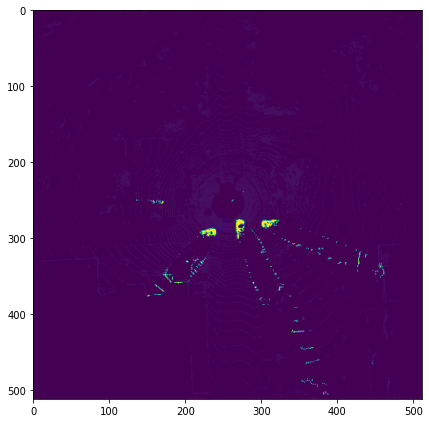

In [97]:
prediction_bev = do_projection(prediction_point_raw, xy, mode="BEV")
prediction_point = do_backprojection(prediction_bev, xy)
prediction_rv = do_projection(prediction_point, theta_phi, mode="RV")
prediction_point = do_backprojection(prediction_rv, theta_phi)
prediction_bev = do_projection(prediction_point, xy, mode="BEV")
pretty_show(prediction_bev)

## 22

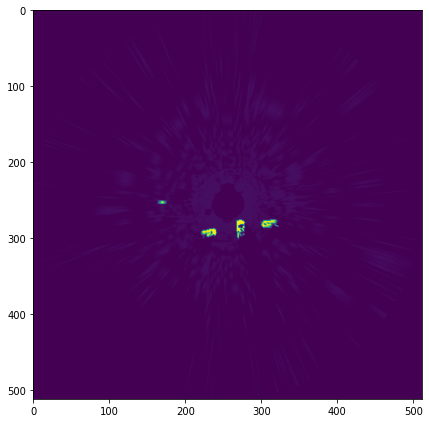

In [102]:
prediction_bev = do_projection(prediction_point_raw, xy, mode="BEV")
tmp_rv = converter_b2r(prediction_bev)
tmp_bev = converter_r2b(tmp_rv)
pretty_show(tmp_bev)

## 232 2트

torch.Size([1, 1, 122026, 1]) torch.Size([1, 122026, 2, 1]) -> torch.Size([1, 1, 64, 2048])
torch.Size([1, 1, 122026, 1]) torch.Size([1, 122026, 2, 1]) -> torch.Size([1, 1, 512, 512])


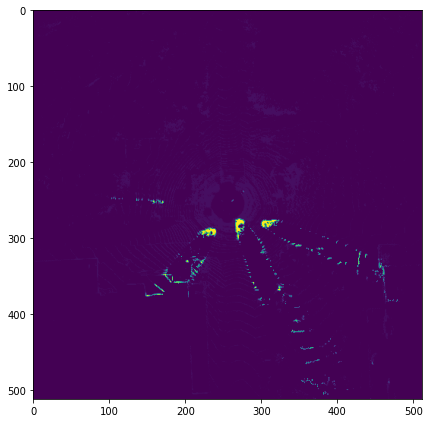

In [62]:
prediction_point = do_backprojection(prediction_bev, xy)
prediction_rv = do_projection(prediction_point, theta_phi, mode="RV")
prediction_point = do_backprojection(prediction_rv, theta_phi)
prediction_bev = do_projection(prediction_point, xy, mode="BEV")
pretty_show(prediction_bev)

## 22 2트

tensor([0.0000e+00, 1.4824e-12, 1.6618e-12,  ..., 2.3601e+02, 2.3675e+02,
        2.4723e+02])


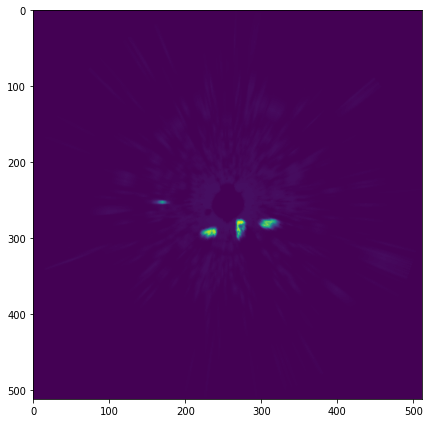

In [73]:
tmp_rv = converter_b2r(tmp_bev)
tmp_bev = converter_r2b(tmp_rv)
pretty_show(tmp_bev)

In [ ]:
torch.unique(prediction_bev), torch.unique(tmp_bev)

TypeError: 'torch.dtype' object is not callable

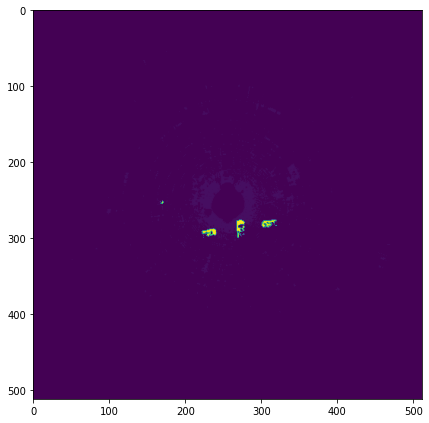

In [100]:
pretty_show(prediction_bev.int() & tmp_bev.int())